# ChurnInsight — Modelo de Churn com XGBoost (Telco) 📉🤖

Este notebook implementa um **MVP de predição de churn** (cancelamento) para empresas de **serviços recorrentes** (Telecom, Fintech, Streaming, E-commerce).

**Objetivos**
- Explorar e entender o dataset (EDA)
- Preparar dados e criar features simples
- Treinar um modelo de **classificação binária** com **XGBoost**
- Avaliar desempenho com métricas clássicas
- Calibrar threshold e faixas de risco (baixo/médio/alto)
- Fazer **tuning** (RandomizedSearch) com foco em **PR-AUC** e **Recall**
- Serializar o **pipeline completo** para uso em uma API (FastAPI/Spring Boot)

📦 Dataset: `WA_Fn-UseC_-Telco-Customer-Churn.csv`

<a id="menu"></a>
## Sumário 🧭

1. [Imports e Configuração](#sec-01)  
2. [Carregamento dos Dados](#sec-02)  
3. [EDA — Análise Exploratória](#sec-03)  
4. [Limpeza e Preparação de X e y](#sec-04)  
5. [Pré-processamento e Engenharia de Atributos](#sec-05)  
6. [Modelo e Pipeline (Baseline)](#sec-06)  
7. [Treinamento](#sec-07)  
8. [Avaliação](#sec-08)  
9. [Serialização do Pipeline (Baseline)](#sec-09)  
10. [Funções de Inferência (Produção/API)](#sec-10)  
11. [Exemplo de Previsão](#sec-11)  
12. [Calibração de Risco (Baixo/Médio/Alto)](#sec-12)  
13. [Fine-tune do Modelo (RandomizedSearch)](#sec-13)  
14. [Serialização do Artefato Tunado](#sec-14)  
15. [Inferência com Artefato Tunado](#sec-15)  
16. [Relatório Baseline vs Tuned](#sec-16)  
17. [Conclusões e narrativa para banca](#sec-17)  
18. [Exemplos de requisição (payloads)](#sec-18)  
19. [Testes via cURL](#sec-19)

<a id="sec-01"></a>
## 1. Imports e Configuração ⚙️

In [1]:
import sys, time, os
from pathlib import Path

print("Python:", sys.executable)
print("Versão:", sys.version)

mods = [
    ("pandas", "import pandas as pd"),
    ("numpy", "import numpy as np"),
    ("seaborn", "import seaborn as sns"),
    ("matplotlib", "import matplotlib.pyplot as plt"),
    ("sklearn", "import sklearn"),
    ("joblib", "import joblib"),
    ("xgboost", "import xgboost"),
]

for name, stmt in mods:
    t0 = time.time()
    print(f"Importando {name}...", end=" ")
    exec(stmt)
    print(f"OK ({time.time()-t0:.2f}s)")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick  # formatação de eixos em %

sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)

from xgboost import XGBClassifier
import joblib

pd.set_option("display.max_columns", 80)

Python: C:\Users\USER\AppData\Local\Programs\Python\Python311\python.exe
Versão: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Importando pandas... 

OK (0.34s)
Importando numpy... OK (0.00s)
Importando seaborn... 

OK (0.85s)
Importando matplotlib... OK (0.00s)
Importando sklearn... OK (0.16s)
Importando joblib... OK (0.00s)
Importando xgboost... 

OK (0.12s)


[⬆ Voltar ao Sumário](#menu)

<a id="sec-02"></a>
## 2. Carregamento dos Dados 📥

In [2]:
from pathlib import Path

def resolver_caminho_dataset(nome="WA_Fn-UseC_-Telco-Customer-Churn.csv"):
    # Caminhos comuns do projeto (notebooks/ -> ../data/raw)
    cwd = Path.cwd()
    candidatos = [
        cwd / "data" / "raw" / nome,
        cwd.parent / "data" / "raw" / nome,
        cwd.parent.parent / "data" / "raw" / nome,
    ]
    for p in candidatos:
        if p.exists():
            return p
    raise FileNotFoundError(
        "Dataset não encontrado. Garanta que exista em data/raw/ e rode o notebook a partir do projeto. "
        f"Caminhos testados: {[str(c) for c in candidatos]}"
    )

dataset_path = resolver_caminho_dataset()
print("📦 Dataset:", dataset_path)

df = pd.read_csv(dataset_path)
print("Formato do dataset:", df.shape)
df.head()

📦 Dataset: C:\Users\USER\Documents\Repositorios\churninsight-nocountry-clean\data\raw\WA_Fn-UseC_-Telco-Customer-Churn.csv
Formato do dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


[⬆ Voltar ao Sumário](#menu)

<a id="sec-03"></a>
## 3. EDA — Análise Exploratória 🔎

In [3]:
print("=== Info do DataFrame ===")
df.info()

print("\n=== Distribuição de Churn (absoluta) ===")
print(df["Churn"].value_counts())

print("\n=== Distribuição de Churn (proporcional) ===")
print(df["Churn"].value_counts(normalize=True))

=== Info do DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

### 3.1 Preparação leve para EDA visual

In [4]:
df_eda = df.copy()

# TotalCharges vem como string com espaços no Telco; converter para numérico para gráficos
df_eda["TotalCharges"] = pd.to_numeric(df_eda["TotalCharges"].replace(" ", np.nan), errors="coerce")

# Target auxiliar binária para taxas (%)
df_eda["Churn_bin"] = (df_eda["Churn"] == "Yes").astype(int)

num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
cat_cols_recomendadas = [
    "Contract", "PaymentMethod", "InternetService",
    "OnlineSecurity", "TechSupport", "PaperlessBilling",
    "SeniorCitizen", "Partner", "Dependents"
]

display(df_eda[num_cols].describe())

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


### 3.2 Missing Values por Coluna

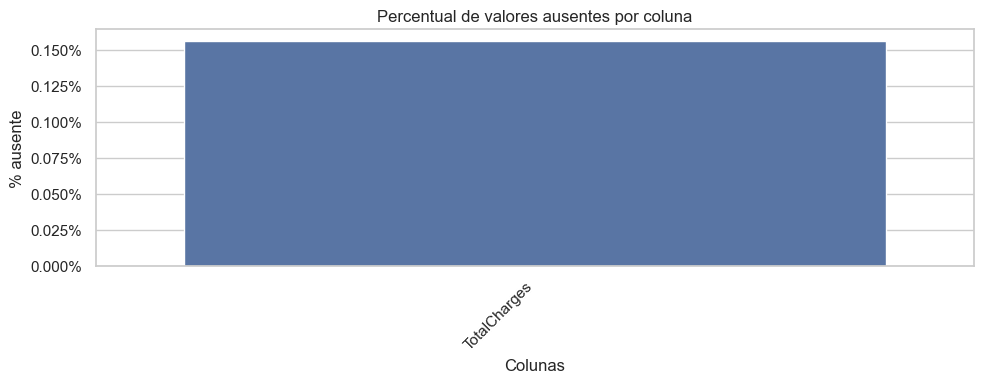

In [5]:
miss = df_eda.isna().mean().sort_values(ascending=False)
miss = miss[miss > 0]

plt.figure(figsize=(10, 4))
ax = sns.barplot(x=miss.index, y=miss.values)
plt.title("Percentual de valores ausentes por coluna")
plt.ylabel("% ausente")
plt.xlabel("Colunas")
plt.xticks(rotation=45, ha="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

### 3.3 Taxa de churn global (indicador)

In [6]:
taxa_churn_global = df_eda["Churn_bin"].mean()
CHURN_BASELINE = taxa_churn_global  # usado em gráficos posteriores
print(f"📌 Taxa global de churn no dataset: {taxa_churn_global:.2%}")

📌 Taxa global de churn no dataset: 26.54%


### 3.4 Churn por variáveis categóricas (taxa %)

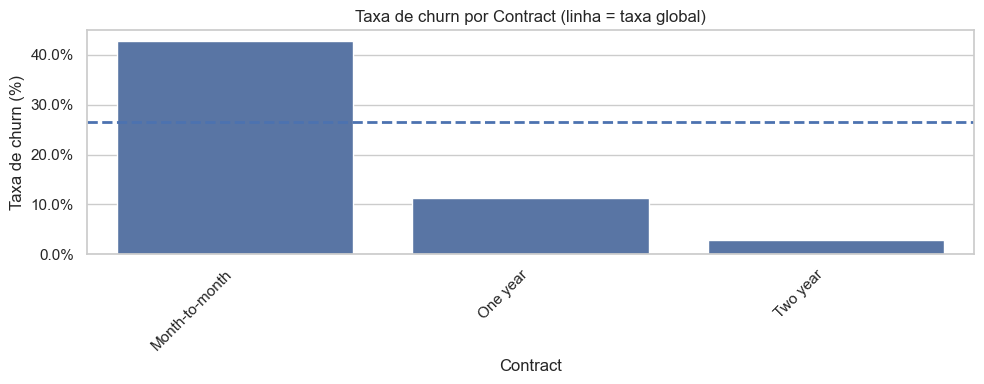

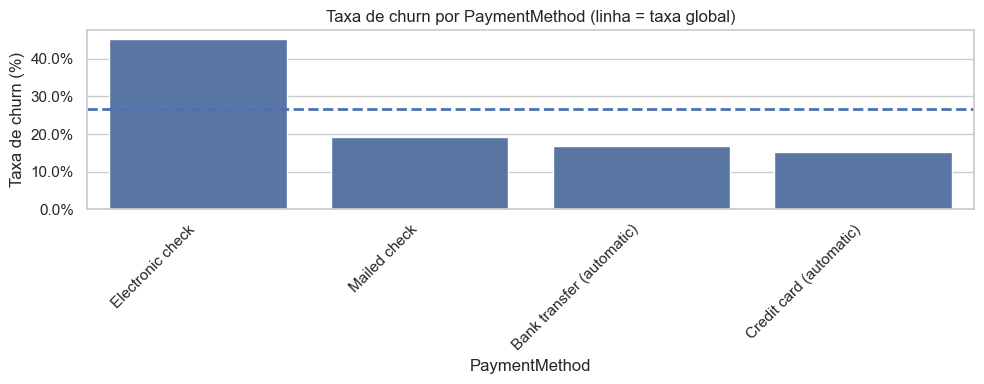

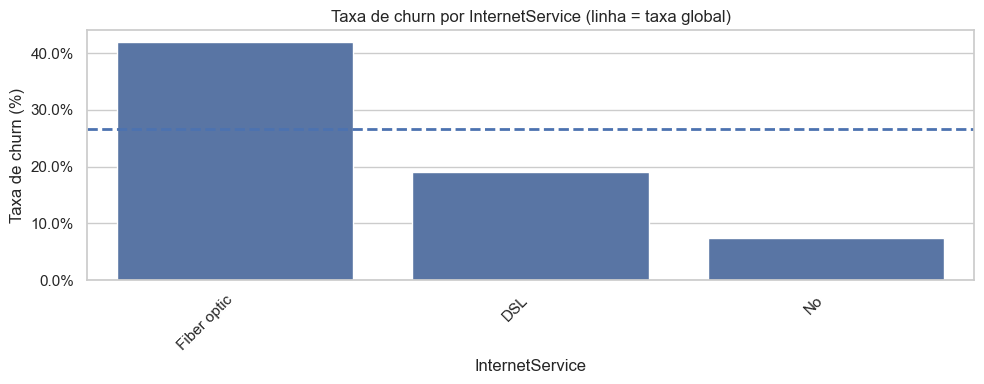

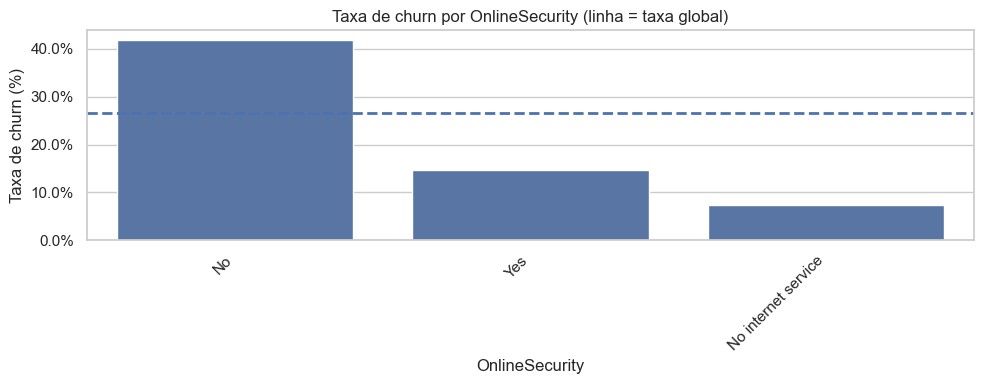

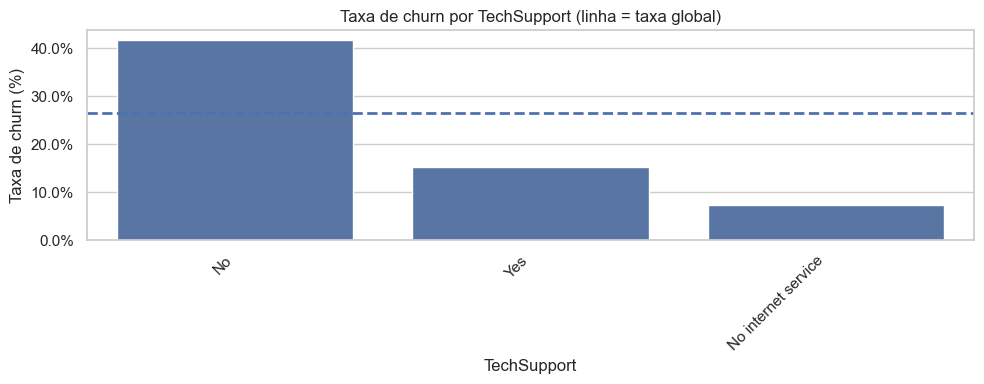

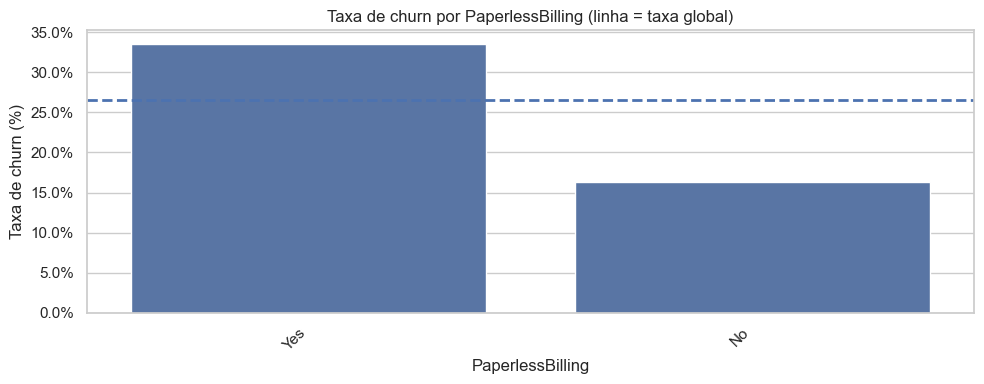

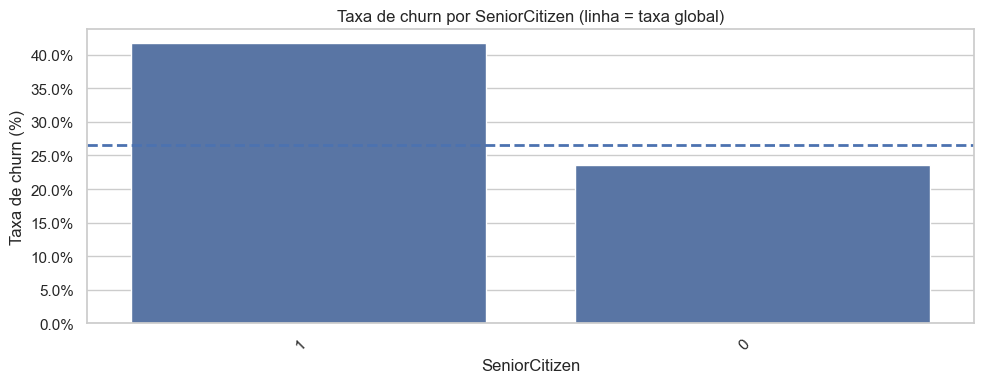

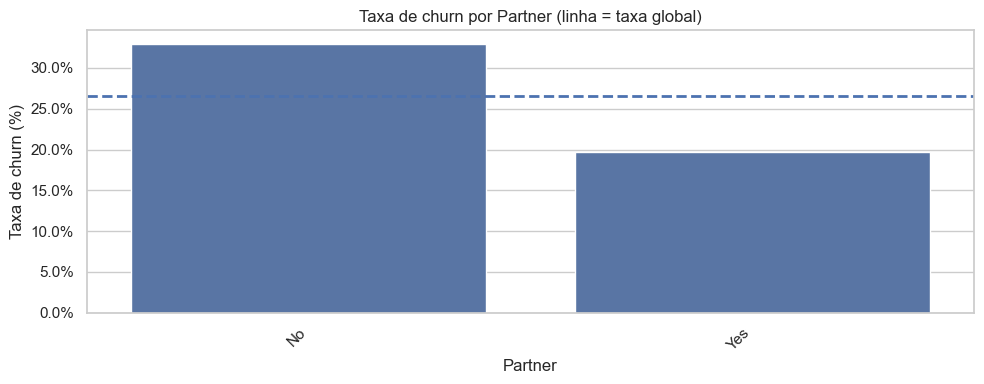

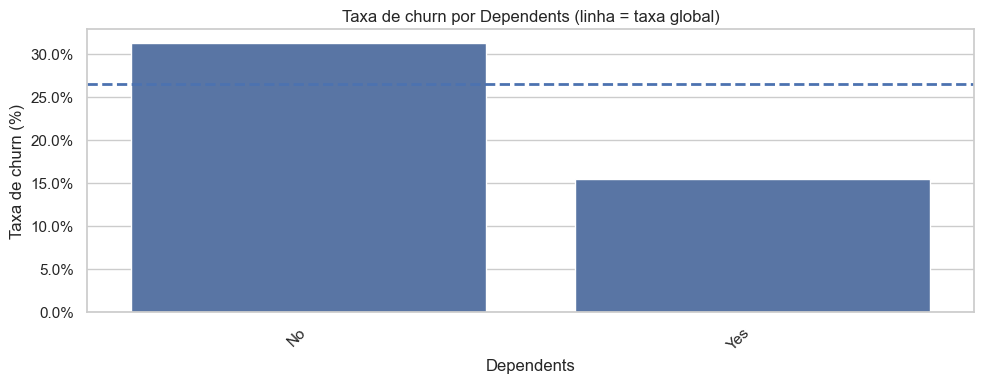

In [7]:
def plot_churn_rate_by_cat(df_in, col, top_n=None):
    tmp = df_in[[col, "Churn_bin"]].copy()
    tmp[col] = tmp[col].astype(str)

    if top_n is not None:
        top = tmp[col].value_counts().head(top_n).index
        tmp = tmp[tmp[col].isin(top)]

    rate = (tmp.groupby(col)["Churn_bin"].mean()
            .sort_values(ascending=False)
            .reset_index(name="taxa_churn"))

    plt.figure(figsize=(10, 4))
    ax = sns.barplot(data=rate, x=col, y="taxa_churn")
    ax.axhline(CHURN_BASELINE, linestyle="--", linewidth=2)
    plt.title(f"Taxa de churn por {col} (linha = taxa global)")
    plt.xlabel(col)
    plt.ylabel("Taxa de churn (%)")
    plt.xticks(rotation=45, ha="right")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.tight_layout()
    plt.show()

for c in cat_cols_recomendadas:
    if c in df_eda.columns:
        plot_churn_rate_by_cat(df_eda, c)

### 3.5 Distribuições numéricas por churn (boxplot + hist)

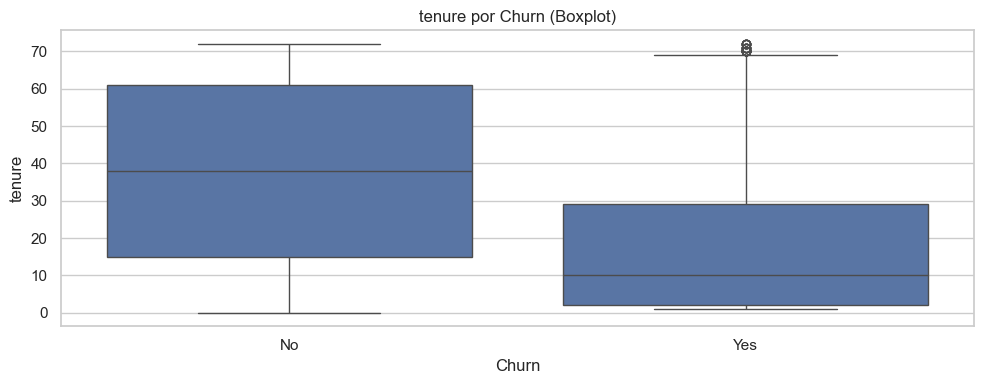

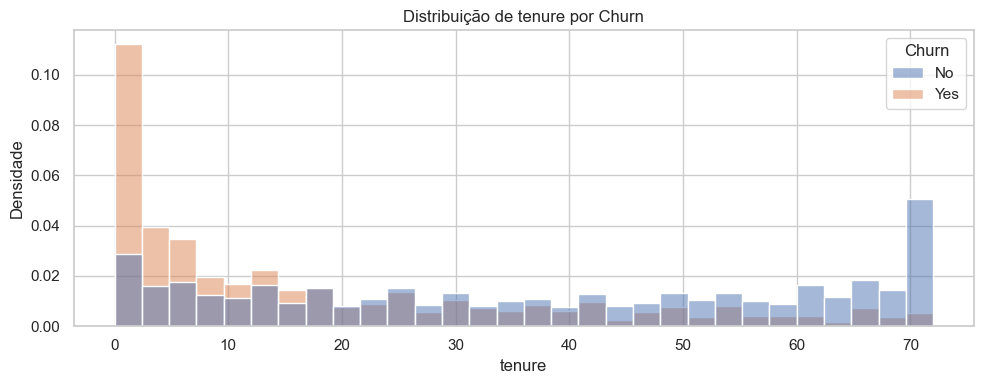

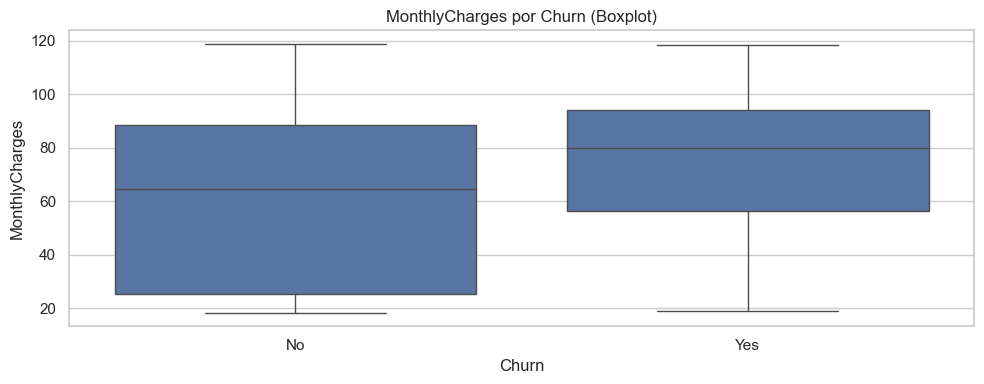

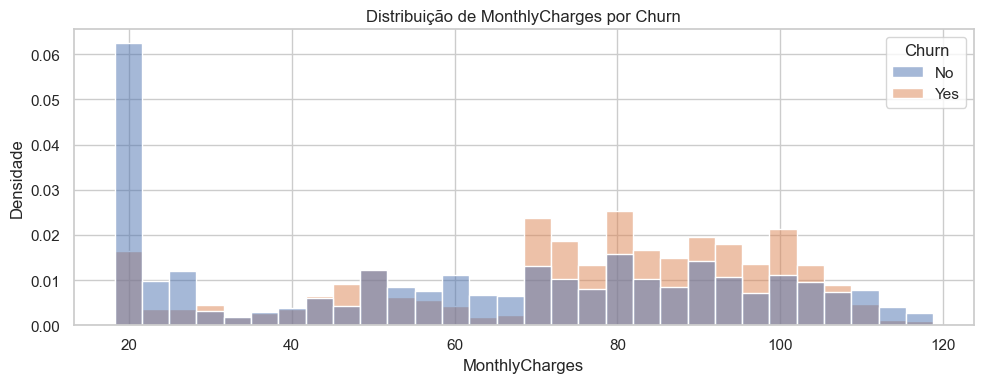

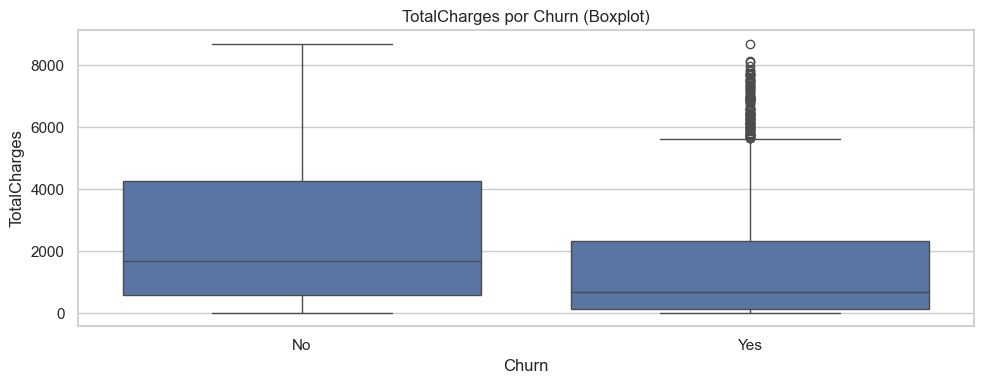

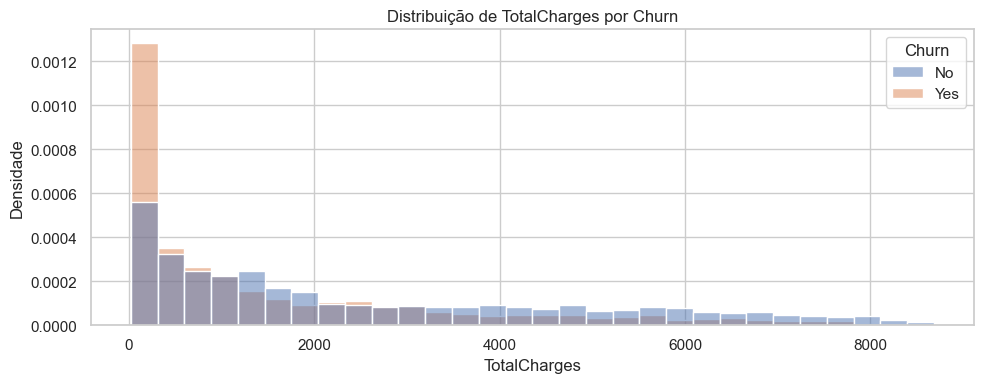

In [8]:
def plot_num_by_churn(df_in, col):
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df_in, x="Churn", y=col)
    plt.title(f"{col} por Churn (Boxplot)")
    plt.xlabel("Churn")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.histplot(data=df_in, x=col, hue="Churn", bins=30, stat="density", common_norm=False)
    plt.title(f"Distribuição de {col} por Churn")
    plt.xlabel(col)
    plt.ylabel("Densidade")
    plt.tight_layout()
    plt.show()

for c in num_cols:
    if c in df_eda.columns:
        plot_num_by_churn(df_eda.dropna(subset=[c]), c)

### 3.6 Heatmap de correlação (numéricas)

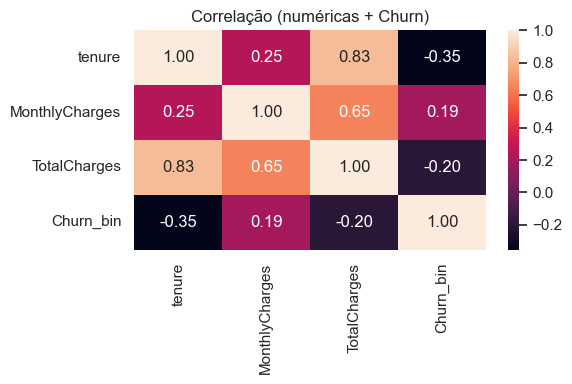

In [9]:
corr = df_eda[num_cols + ["Churn_bin"]].corr(numeric_only=True)

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlação (numéricas + Churn)")
plt.tight_layout()
plt.show()

### 3.7 Churn por faixas de tenure

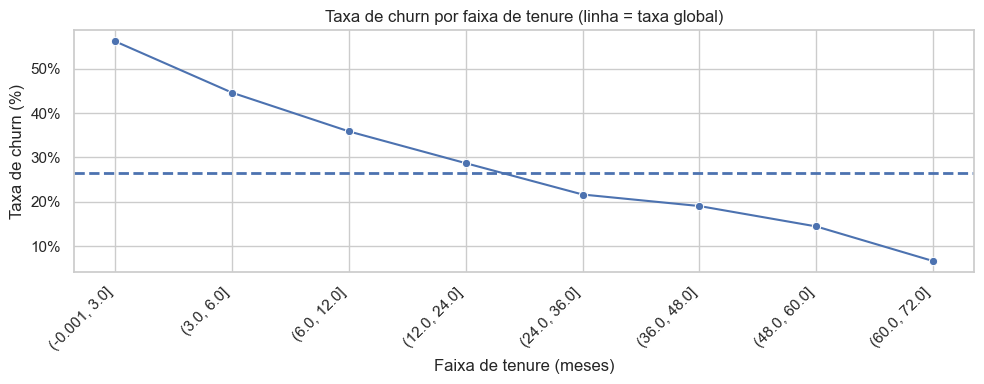

In [10]:
bins_tenure = [0, 3, 6, 12, 24, 36, 48, 60, 72]
df_t = df_eda.dropna(subset=["tenure"]).copy()
df_t["tenure_bin"] = pd.cut(df_t["tenure"], bins=bins_tenure, include_lowest=True)

rate_tenure = (
    df_t.groupby("tenure_bin", observed=True)["Churn_bin"]
    .mean()
    .reset_index(name="taxa_churn")
)

rate_tenure["tenure_bin_str"] = rate_tenure["tenure_bin"].astype(str)
rate_tenure = rate_tenure.sort_values("tenure_bin")

plt.figure(figsize=(10, 4))
ax = sns.lineplot(data=rate_tenure, x="tenure_bin_str", y="taxa_churn", marker="o")
ax.axhline(CHURN_BASELINE, linestyle="--", linewidth=2)
plt.title("Taxa de churn por faixa de tenure (linha = taxa global)")
plt.xlabel("Faixa de tenure (meses)")
plt.ylabel("Taxa de churn (%)")
plt.xticks(rotation=45, ha="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

[⬆ Voltar ao Sumário](#menu)

<a id="sec-04"></a>
## 4. Limpeza e Preparação de X e y 🧹

In [11]:
# Converter TotalCharges para numérico (há valores em branco representados como espaço)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"].replace(" ", np.nan), errors="coerce")

# Preencher valores ausentes em TotalCharges com a mediana
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Remover qualquer linha eventualmente sem target
df = df.dropna(subset=["Churn"])

# Target binário: 0 = No, 1 = Yes
y = df["Churn"].map({"No": 0, "Yes": 1})

# Features: removemos customerID e Churn
X = df.drop(columns=["customerID", "Churn"])

print("✅ Dados prontos.")
print("X shape:", X.shape, "| y mean (taxa churn):", round(y.mean(), 4))
X.head()

✅ Dados prontos.
X shape: (7043, 19) | y mean (taxa churn): 0.2654


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


[⬆ Voltar ao Sumário](#menu)

<a id="sec-05"></a>
## 5. Pré-processamento e Engenharia de Atributos 🧩

In [12]:
numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Colunas numéricas:", numeric_features)
print("Colunas categóricas (qtd):", len(categorical_features))

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ]
)

preprocess

Colunas numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Colunas categóricas (qtd): 15


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

[⬆ Voltar ao Sumário](#menu)

<a id="sec-06"></a>
## 6. Modelo e Pipeline (Baseline) 🧠

In [13]:
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=1,
)

clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", xgb_model),
    ]
)

clf

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

[⬆ Voltar ao Sumário](#menu)

<a id="sec-07"></a>
## 7. Treinamento 🏋️

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Tamanho treino:", X_train.shape)
print("Tamanho teste :", X_test.shape)

clf.fit(X_train, y_train)
print("✅ Treinamento concluído.")

Tamanho treino: (5634, 19)
Tamanho teste : (1409, 19)
✅ Treinamento concluído.


[⬆ Voltar ao Sumário](#menu)

<a id="sec-08"></a>
## 8. Avaliação 📊

=== Métricas no conjunto de teste (Baseline @ thr=0.5) ===


Acurácia : 0.7970
Precisão : 0.6497
Recall   : 0.5107
F1-score : 0.5719
ROC AUC  : 0.8390

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



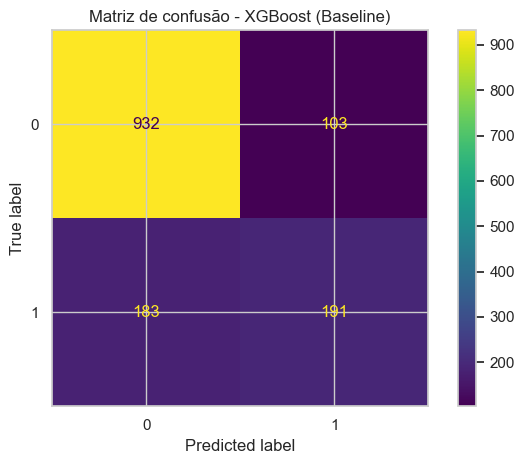

In [15]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)

print("=== Métricas no conjunto de teste (Baseline @ thr=0.5) ===")
print(f"Acurácia : {accuracy:.4f}")
print(f"Precisão : {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, zero_division=0))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de confusão - XGBoost (Baseline)")
plt.tight_layout()
plt.show()

[⬆ Voltar ao Sumário](#menu)

<a id="sec-09"></a>
## 9. Serialização do Pipeline (Baseline) 💾

In [16]:
# Salvar pipeline completo (pré-processamento + modelo)
cwd = Path.cwd()
model_dir = (cwd.parent / "model") if (cwd.name.lower() == "notebooks") else (cwd / "model")
model_dir.mkdir(parents=True, exist_ok=True)

nome_arquivo_modelo = model_dir / "churn_xgboost_pipeline.joblib"
joblib.dump(clf, nome_arquivo_modelo)
print(f"✅ Pipeline salvo em: {nome_arquivo_modelo}")

✅ Pipeline salvo em: C:\Users\USER\Documents\Repositorios\churninsight-nocountry-clean\model\churn_xgboost_pipeline.joblib


[⬆ Voltar ao Sumário](#menu)

<a id="sec-10"></a>
## 10. Funções de Inferência (Produção/API) 🧪

In [17]:
def carregar_modelo(caminho_modelo: str = None):
    # Carrega o pipeline de churn treinado (pré-processamento + XGBoost).
    if caminho_modelo is None:
        caminho_modelo = str(nome_arquivo_modelo)
    return joblib.load(caminho_modelo)

def prever_cliente(dados_cliente: dict, modelo=None, threshold: float = 0.5):
    # Recebe dict com os dados do cliente e retorna previsão e probabilidade.
    if modelo is None:
        modelo = carregar_modelo()

    X_novo = pd.DataFrame([dados_cliente])

    colunas_esperadas = list(X.columns)
    faltando = set(colunas_esperadas) - set(X_novo.columns)
    sobrando = set(X_novo.columns) - set(colunas_esperadas)

    if faltando:
        raise ValueError(f"❌ Faltam colunas na entrada: {sorted(list(faltando))}")
    if sobrando:
        raise ValueError(f"❌ Existem colunas não reconhecidas: {sorted(list(sobrando))}")

    X_novo = X_novo[colunas_esperadas]

    prob = float(modelo.predict_proba(X_novo)[:, 1][0])
    pred = int(prob >= threshold)

    return {
        "previsao": "Vai cancelar" if pred == 1 else "Vai continuar",
        "probabilidade": prob,
        "threshold_usado": float(threshold),
    }

[⬆ Voltar ao Sumário](#menu)

<a id="sec-11"></a>
## 11. Exemplo de Previsão 🧾

In [18]:
exemplo_cliente = {
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "No",
    "tenure": 12,
    "PhoneService": "Yes",
    "MultipleLines": "No",
    "InternetService": "Fiber optic",
    "OnlineSecurity": "No",
    "OnlineBackup": "Yes",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "Yes",
    "StreamingMovies": "No",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 70.35,
    "TotalCharges": 151.65,
}

modelo_carregado = carregar_modelo()
resultado = prever_cliente(exemplo_cliente, modelo=modelo_carregado, threshold=0.5)
resultado

{'previsao': 'Vai cancelar',
 'probabilidade': 0.6119151711463928,
 'threshold_usado': 0.5}

[⬆ Voltar ao Sumário](#menu)

<a id="sec-12"></a>
## 12. Calibração de Risco (Baixo/Médio/Alto) 🚦

In [19]:
df_eval = pd.DataFrame({
    "y_true": y_test.values,
    "prob_churn": y_proba
})

df_eval.head()

,y_true,prob_churn
0,0,0.006583
1,0,0.889237
2,0,0.085328
3,0,0.322373
4,0,0.005312


### 12.1 Distribuição das probabilidades

In [20]:
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]

df_eval["prob_bin"] = pd.cut(
    df_eval["prob_churn"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

dist_prob = df_eval["prob_bin"].value_counts().sort_index()
print("=== Distribuição de clientes por faixa de probabilidade ===")
print(dist_prob)

=== Distribuição de clientes por faixa de probabilidade ===
prob_bin
0–0.2      760
0.2–0.4    226
0.4–0.6    219
0.6–0.8    136
0.8–1.0     68
Name: count, dtype: int64


### 12.2 Churn real por faixa

In [21]:
stats_bins = (
    df_eval
    .groupby("prob_bin", observed=True)
    .agg(
        total_clientes=("y_true", "count"),
        churns_reais=("y_true", "sum"),
    )
)

stats_bins["taxa_churn_real"] = stats_bins["churns_reais"] / stats_bins["total_clientes"]

print("=== Churn real por faixa de probabilidade prevista ===")
display(stats_bins)

taxa_churn_global_teste = df_eval["y_true"].mean()
print(f"\n📌 Taxa global de churn no teste: {taxa_churn_global_teste:.4f}")

=== Churn real por faixa de probabilidade prevista ===


,total_clientes,churns_reais,taxa_churn_real
prob_bin,,,
0–0.2,760,61,0.080263
0.2–0.4,226,67,0.296460
0.4–0.6,219,100,0.456621
0.6–0.8,136,90,0.661765
0.8–1.0,68,56,0.823529



📌 Taxa global de churn no teste: 0.2654


### 12.3 Teste de cutoffs para risco (Baixo/Médio/Alto)

In [22]:
def classificar_risco(prob, thr_medio, thr_alto):
    if prob >= thr_alto:
        return "alto"
    elif prob >= thr_medio:
        return "medio"
    else:
        return "baixo"

thresholds_medio = [0.3, 0.4, 0.5]
thresholds_alto  = [0.6, 0.7, 0.8]

resultados = []

for thr_m in thresholds_medio:
    for thr_a in thresholds_alto:
        if thr_a <= thr_m:
            continue

        df_tmp = df_eval.copy()
        df_tmp["risco"] = df_tmp["prob_churn"].apply(lambda p: classificar_risco(p, thr_m, thr_a))

        resumo = (
            df_tmp
            .groupby("risco")
            .agg(
                total_clientes=("y_true", "count"),
                churns_reais=("y_true", "sum")
            )
        )

        resumo["taxa_churn_real"] = resumo["churns_reais"] / resumo["total_clientes"]

        resultados.append({
            "thr_medio": thr_m,
            "thr_alto": thr_a,
            "total_alto": resumo.loc["alto", "total_clientes"] if "alto" in resumo.index else 0,
            "taxa_alto": resumo.loc["alto", "taxa_churn_real"] if "alto" in resumo.index else float("nan"),
            "total_medio": resumo.loc["medio", "total_clientes"] if "medio" in resumo.index else 0,
            "taxa_medio": resumo.loc["medio", "taxa_churn_real"] if "medio" in resumo.index else float("nan"),
            "total_baixo": resumo.loc["baixo", "total_clientes"] if "baixo" in resumo.index else 0,
            "taxa_baixo": resumo.loc["baixo", "taxa_churn_real"] if "baixo" in resumo.index else float("nan"),
        })

df_thresholds = pd.DataFrame(resultados)
df_thresholds.sort_values("taxa_alto", ascending=False).head(10)

,thr_medio,thr_alto,total_alto,taxa_alto,total_medio,taxa_medio,total_baixo,taxa_baixo
2,0.3,0.8,68,0.823529,459,0.488017,882,0.106576
8,0.5,0.8,68,0.823529,226,0.597345,1115,0.164126
5,0.4,0.8,68,0.823529,355,0.535211,986,0.129817
7,0.5,0.7,135,0.755556,159,0.559748,1115,0.164126
1,0.3,0.7,135,0.755556,392,0.454082,882,0.106576
4,0.4,0.7,135,0.755556,288,0.500000,986,0.129817
0,0.3,0.6,204,0.715686,323,0.414861,882,0.106576
3,0.4,0.6,204,0.715686,219,0.456621,986,0.129817
6,0.5,0.6,204,0.715686,90,0.500000,1115,0.164126


[⬆ Voltar ao Sumário](#menu)

<a id="sec-13"></a>
## 13. Fine-tune do Modelo (RandomizedSearch) 🎛️⚡

In [23]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

X_train_ft, X_val, y_train_ft, y_val = train_test_split(
    X_train, y_train,
    test_size=0.25,
    random_state=42,
    stratify=y_train
)

print("📦 Shapes:")
print(" - Train (FT):", X_train_ft.shape)
print(" - Val       :", X_val.shape)
print(" - Test      :", X_test.shape)

n_pos = int((y_train_ft == 1).sum())
n_neg = int((y_train_ft == 0).sum())
scale_pos_weight = n_neg / max(n_pos, 1)

print(f"⚖️ Desbalanceamento no treino (FT): pos={n_pos}, neg={n_neg}")
print(f"✅ scale_pos_weight = {scale_pos_weight:.4f}")

📦 Shapes:
 - Train (FT): (4225, 19)
 - Val       : (1409, 19)
 - Test      : (1409, 19)
⚖️ Desbalanceamento no treino (FT): pos=1121, neg=3104
✅ scale_pos_weight = 2.7690


### 13.1 Configuração do tuning

In [24]:
N_ITER = 25
CV_SPLITS = 5
N_JOBS = 1  # Windows local: evita warnings do joblib

xgb_model_tune = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    random_state=42,
    n_jobs=N_JOBS,
    tree_method="hist",
    scale_pos_weight=scale_pos_weight
)

clf_tune = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", xgb_model_tune),
    ]
)

cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=42)

param_distributions = {
    "model__n_estimators": [200, 300, 400, 600, 800],
    "model__max_depth": [2, 3, 4, 5, 6],
    "model__learning_rate": [0.02, 0.05, 0.08, 0.1, 0.15, 0.2],
    "model__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__min_child_weight": [1, 2, 3, 5, 7, 10],
    "model__gamma": [0, 0.5, 1, 2, 5],
    "model__reg_alpha": [0, 0.01, 0.05, 0.1, 0.5, 1.0],
    "model__reg_lambda": [0.5, 1.0, 2.0, 3.0, 5.0],
    "model__max_delta_step": [0, 1, 5],
    "model__scale_pos_weight": [scale_pos_weight * 0.75, scale_pos_weight, scale_pos_weight * 1.25],
}

search = RandomizedSearchCV(
    estimator=clf_tune,
    param_distributions=param_distributions,
    n_iter=N_ITER,
    scoring="average_precision",
    cv=cv,
    verbose=1,
    n_jobs=N_JOBS,
    random_state=42,
    refit=True
)

print("🚀 Iniciando RandomizedSearchCV...")
search.fit(X_train_ft, y_train_ft)

print("\n🏁 Tuning finalizado.")
print("⭐ Melhor PR-AUC (CV):", round(search.best_score_, 6))
print("🧩 Melhores parâmetros:", search.best_params_)

best_model = search.best_estimator_

🚀 Iniciando RandomizedSearchCV...
Fitting 5 folds for each of 25 candidates, totalling 125 fits



🏁 Tuning finalizado.
⭐ Melhor PR-AUC (CV): 0.676938
🧩 Melhores parâmetros: {'model__subsample': 0.7, 'model__scale_pos_weight': 2.768956289027654, 'model__reg_lambda': 2.0, 'model__reg_alpha': 0.5, 'model__n_estimators': 600, 'model__min_child_weight': 3, 'model__max_depth': 2, 'model__max_delta_step': 0, 'model__learning_rate': 0.02, 'model__gamma': 1, 'model__colsample_bytree': 0.8}


### 13.2 Escolha de Threshold (Validação)

In [25]:
def escolher_threshold_max_f1(y_true, proba, grid=np.linspace(0.05, 0.95, 91)):
    melhor_thr, melhor_f1 = 0.5, -1
    for thr in grid:
        pred = (proba >= thr).astype(int)
        f1 = f1_score(y_true, pred, zero_division=0)
        if f1 > melhor_f1:
            melhor_f1 = f1
            melhor_thr = float(thr)
    return melhor_thr, melhor_f1

def escolher_threshold_precision_min(y_true, proba, precision_min=0.50, grid=np.linspace(0.05, 0.95, 91)):
    melhor_thr, melhor_recall = None, -1
    for thr in grid:
        pred = (proba >= thr).astype(int)
        p = precision_score(y_true, pred, zero_division=0)
        r = recall_score(y_true, pred, zero_division=0)
        if p >= precision_min and r > melhor_recall:
            melhor_recall = r
            melhor_thr = float(thr)
    return melhor_thr, melhor_recall

val_proba = best_model.predict_proba(X_val)[:, 1]

thr_f1, val_f1 = escolher_threshold_max_f1(y_val, val_proba)
thr_prec, val_rec = escolher_threshold_precision_min(y_val, val_proba, precision_min=0.50)

print(f"🎯 Threshold (max F1) no VAL: {thr_f1:.2f} | F1={val_f1:.4f}")
if thr_prec is not None:
    print(f"📌 Threshold (Precision>=0.50) no VAL: {thr_prec:.2f} | Recall={val_rec:.4f}")
else:
    print("⚠️ Não foi possível atingir Precision>=0.50 com a grade de thresholds.")

threshold_escolhido = thr_f1
print(f"✅ Threshold escolhido para produção/API: {threshold_escolhido:.2f}")

🎯 Threshold (max F1) no VAL: 0.63 | F1=0.6474
📌 Threshold (Precision>=0.50) no VAL: 0.47 | Recall=0.8262
✅ Threshold escolhido para produção/API: 0.63


### 13.3 Avaliação Final no Teste (Tuned + Threshold do VAL)

=== MÉTRICAS NO TESTE (Tuned + Threshold do VAL) ===
Threshold: 0.63
Accuracy : 0.789922
Precision: 0.588235
Recall   : 0.695187
F1       : 0.637255
ROC-AUC  : 0.848121
PR-AUC   : 0.67046

=== Classification Report (Tuned) ===
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1035
           1       0.59      0.70      0.64       374

    accuracy                           0.79      1409
   macro avg       0.74      0.76      0.74      1409
weighted avg       0.80      0.79      0.80      1409



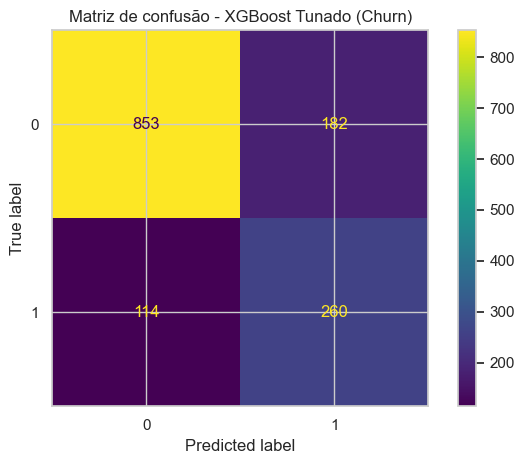

In [26]:
test_proba_tuned = best_model.predict_proba(X_test)[:, 1]
test_pred_tuned = (test_proba_tuned >= threshold_escolhido).astype(int)

print("=== MÉTRICAS NO TESTE (Tuned + Threshold do VAL) ===")
print("Threshold:", round(threshold_escolhido, 4))
print("Accuracy :", round(accuracy_score(y_test, test_pred_tuned), 6))
print("Precision:", round(precision_score(y_test, test_pred_tuned, zero_division=0), 6))
print("Recall   :", round(recall_score(y_test, test_pred_tuned, zero_division=0), 6))
print("F1       :", round(f1_score(y_test, test_pred_tuned, zero_division=0), 6))
print("ROC-AUC  :", round(roc_auc_score(y_test, test_proba_tuned), 6))
print("PR-AUC   :", round(average_precision_score(y_test, test_proba_tuned), 6))

print("\n=== Classification Report (Tuned) ===")
print(classification_report(y_test, test_pred_tuned, zero_division=0))

disp = ConfusionMatrixDisplay.from_predictions(y_test, test_pred_tuned)
plt.title("Matriz de confusão - XGBoost Tunado (Churn)")
plt.tight_layout()
plt.show()

[⬆ Voltar ao Sumário](#menu)

<a id="sec-14"></a>
## 14. Serialização do Artefato Tunado 💾📦

In [27]:
artefato_tuned = {
    "model": best_model,
    "threshold": float(threshold_escolhido),
    "features": list(X.columns),
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "best_params": search.best_params_,
    "best_cv_pr_auc": float(search.best_score_),
}

out_path_tuned = model_dir / "churn_xgboost_pipeline_tuned.joblib"
joblib.dump(artefato_tuned, out_path_tuned)

print(f"✅ Artefato tunado salvo em: {out_path_tuned}")

✅ Artefato tunado salvo em: C:\Users\USER\Documents\Repositorios\churninsight-nocountry-clean\model\churn_xgboost_pipeline_tuned.joblib


[⬆ Voltar ao Sumário](#menu)

<a id="sec-15"></a>
## 15. Inferência com Artefato Tunado 🧩🧪

In [28]:
def carregar_artefato(caminho: str = None) -> dict:
    if caminho is None:
        caminho = str(out_path_tuned)
    artefato = joblib.load(caminho)

    obrigatorias = {"model", "threshold", "features"}
    faltando = obrigatorias - set(artefato.keys())
    if faltando:
        raise ValueError(f"❌ Artefato inválido. Faltam chaves: {faltando}")

    thr = float(artefato["threshold"])
    if not (0.0 <= thr <= 1.0):
        raise ValueError("❌ Artefato inválido: 'threshold' deve estar entre 0 e 1.")

    feats = artefato["features"]
    if not isinstance(feats, (list, tuple)) or len(feats) == 0:
        raise ValueError("❌ Artefato inválido: 'features' deve ser uma lista não vazia.")

    return artefato

def prever_cliente_com_artefato(dados_cliente: dict, artefato: dict = None) -> dict:
    if artefato is None:
        artefato = carregar_artefato()

    modelo = artefato["model"]
    threshold = float(artefato["threshold"])
    features = list(artefato["features"])

    X_novo = pd.DataFrame([dados_cliente])

    faltando = set(features) - set(X_novo.columns)
    sobrando = set(X_novo.columns) - set(features)

    if faltando:
        raise ValueError(f"❌ Entrada inválida. Faltam campos: {sorted(list(faltando))}")
    if sobrando:
        raise ValueError(f"❌ Entrada inválida. Campos não reconhecidos: {sorted(list(sobrando))}")

    X_novo = X_novo[features]

    # Coerção de numéricos (tolerância a strings numéricas vindas da API)
    numeric_feats = artefato.get("numeric_features", [])
    for col in numeric_feats:
        if col in X_novo.columns:
            X_novo[col] = pd.to_numeric(X_novo[col], errors="coerce")

    cols_nan = [c for c in numeric_feats if c in X_novo.columns and X_novo[c].isna().any()]
    if cols_nan:
        raise ValueError(f"❌ Entrada inválida. Numéricos não convertidos corretamente: {cols_nan}")

    prob = float(modelo.predict_proba(X_novo)[:, 1][0])
    pred = int(prob >= threshold)

    return {
        "previsao": "Vai cancelar" if pred == 1 else "Vai continuar",
        "probabilidade": prob,
        "threshold_usado": threshold,
    }

artefato = carregar_artefato()
resultado_tuned = prever_cliente_com_artefato(exemplo_cliente, artefato)
print("🧾 Resultado (Tuned):", resultado_tuned)

🧾 Resultado (Tuned): {'previsao': 'Vai cancelar', 'probabilidade': 0.775445818901062, 'threshold_usado': 0.63}


[⬆ Voltar ao Sumário](#menu)

<a id="sec-16"></a>
## 16. Relatório Baseline vs Tuned 📊🧪

### Por que o modelo tunado pode ter acurácia menor e ainda ser melhor?

Em churn, a classe **positiva** (churn=1) costuma ser minoria. Acurácia pode ficar “bonita” mesmo quando o modelo erra churn,
porque acertar “não churn” é numericamente mais fácil.

Por isso, em um MVP de churn, a banca costuma olhar com bons olhos:
- **Recall** (capturar mais churners para agir antes do cancelamento)
- **PR-AUC** (melhor leitura quando há desbalanceamento)
- **F1** (equilíbrio entre precision/recall)

Além disso, o **threshold (cutoff)** raramente deve ser 0,5. Ele é calibrado para reduzir churn “perdido” (FN) e adequar o volume
de clientes à capacidade do time de retenção.

In [29]:
def avaliar_modelo(y_true, proba, threshold=0.5):
    pred = (proba >= threshold).astype(int)
    return {
        "threshold": float(threshold),
        "accuracy": float(accuracy_score(y_true, pred)),
        "precision": float(precision_score(y_true, pred, zero_division=0)),
        "recall": float(recall_score(y_true, pred, zero_division=0)),
        "f1": float(f1_score(y_true, pred, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_true, proba)),
        "pr_auc": float(average_precision_score(y_true, proba)),
    }

baseline_metrics = avaliar_modelo(y_test, y_proba, threshold=0.5)
tuned_metrics = avaliar_modelo(y_test, test_proba_tuned, threshold=float(threshold_escolhido))

df_compare = pd.DataFrame(
    [
        {"modelo": "Baseline 🧠", **baseline_metrics},
        {"modelo": "Tuned 🎛️", **tuned_metrics},
    ]
)

df_show = df_compare.copy()
for col in ["accuracy", "precision", "recall", "f1", "roc_auc", "pr_auc"]:
    df_show[col] = df_show[col].map(lambda x: f"{x:.4f}")
df_show["threshold"] = df_show["threshold"].map(lambda x: f"{x:.2f}")

display(df_show)

delta = {k: tuned_metrics[k] - baseline_metrics[k] for k in ["accuracy","precision","recall","f1","roc_auc","pr_auc"]}
print("\n📌 Delta (Tuned - Baseline):")
for k, v in delta.items():
    print(f" - {k}: {v:+.4f}")

,modelo,threshold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,Baseline 🧠,0.50,0.7970,0.6497,0.5107,0.5719,0.8390,0.6508
1,Tuned 🎛️,0.63,0.7899,0.5882,0.6952,0.6373,0.8481,0.6705



📌 Delta (Tuned - Baseline):
 - accuracy: -0.0071
 - precision: -0.0614
 - recall: +0.1845
 - f1: +0.0654
 - roc_auc: +0.0091
 - pr_auc: +0.0196


### 16.2 Curvas ROC e Precision-Recall

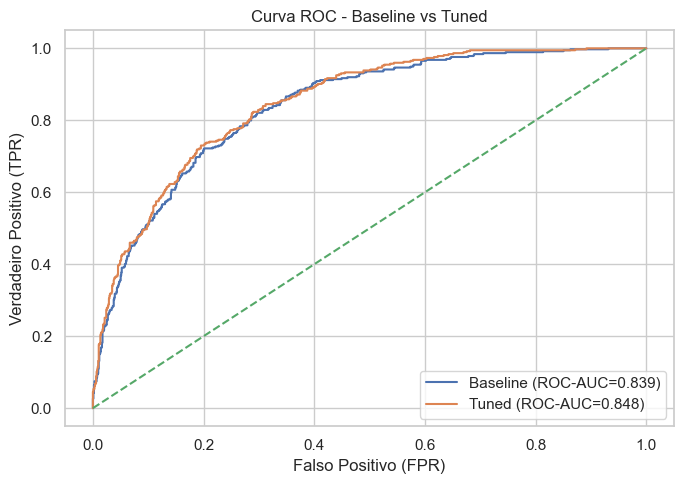

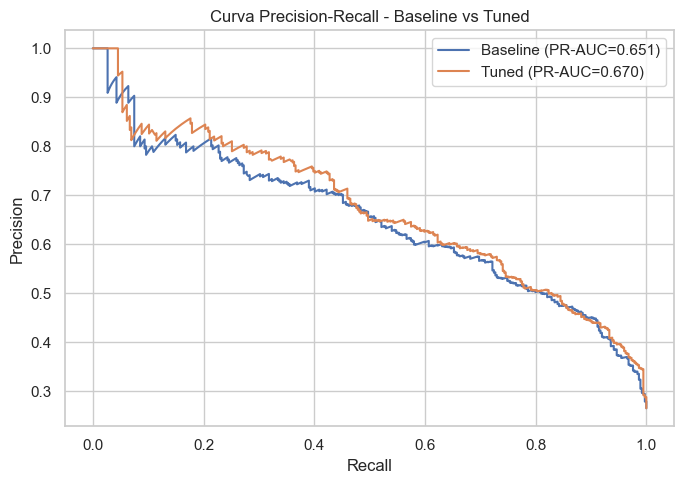

In [30]:
fpr_b, tpr_b, _ = roc_curve(y_test, y_proba)
fpr_t, tpr_t, _ = roc_curve(y_test, test_proba_tuned)

plt.figure(figsize=(7,5))
plt.plot(fpr_b, tpr_b, label=f"Baseline (ROC-AUC={baseline_metrics['roc_auc']:.3f})")
plt.plot(fpr_t, tpr_t, label=f"Tuned (ROC-AUC={tuned_metrics['roc_auc']:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("Curva ROC - Baseline vs Tuned")
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.legend()
plt.tight_layout()
plt.show()

prec_b, rec_b, _ = precision_recall_curve(y_test, y_proba)
prec_t, rec_t, _ = precision_recall_curve(y_test, test_proba_tuned)

plt.figure(figsize=(7,5))
plt.plot(rec_b, prec_b, label=f"Baseline (PR-AUC={baseline_metrics['pr_auc']:.3f})")
plt.plot(rec_t, prec_t, label=f"Tuned (PR-AUC={tuned_metrics['pr_auc']:.3f})")
plt.title("Curva Precision-Recall - Baseline vs Tuned")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

[⬆ Voltar ao Sumário](#menu)

<a id="sec-17"></a>
## 17. Conclusões e narrativa para banca ✅

In [31]:
def fmt_pct(x): 
    return f"{x*100:.2f}%"

def fmt_delta_pp(x):
    sign = "+" if x >= 0 else ""
    return f"{sign}{x*100:.2f} p.p."

texto = f'''
📌 Resumo Executivo (Baseline vs Tuned)

🧠 Baseline (thr=0.50)
- Precision: {fmt_pct(baseline_metrics['precision'])}
- Recall:    {fmt_pct(baseline_metrics['recall'])}
- F1:        {fmt_pct(baseline_metrics['f1'])}
- ROC-AUC:   {baseline_metrics['roc_auc']:.4f}
- PR-AUC:    {baseline_metrics['pr_auc']:.4f}

🎛️ Tuned (thr={tuned_metrics['threshold']:.2f})
- Precision: {fmt_pct(tuned_metrics['precision'])} ({fmt_delta_pp(delta['precision'])})
- Recall:    {fmt_pct(tuned_metrics['recall'])} ({fmt_delta_pp(delta['recall'])})
- F1:        {fmt_pct(tuned_metrics['f1'])} ({fmt_delta_pp(delta['f1'])})
- ROC-AUC:   {tuned_metrics['roc_auc']:.4f} ({delta['roc_auc']:+.4f})
- PR-AUC:    {tuned_metrics['pr_auc']:.4f} ({delta['pr_auc']:+.4f})

✅ Interpretação para o negócio:
- Para churn, muitas vezes é melhor aumentar Recall/PR-AUC do que maximizar acurácia.
- O threshold é calibrado para alinhar decisão com operação (capacidade de retenção) e evitar churn perdido.
'''
print(texto)


📌 Resumo Executivo (Baseline vs Tuned)

🧠 Baseline (thr=0.50)
- Precision: 64.97%
- Recall:    51.07%
- F1:        57.19%
- ROC-AUC:   0.8390
- PR-AUC:    0.6508

🎛️ Tuned (thr=0.63)
- Precision: 58.82% (-6.14 p.p.)
- Recall:    69.52% (+18.45 p.p.)
- F1:        63.73% (+6.54 p.p.)
- ROC-AUC:   0.8481 (+0.0091)
- PR-AUC:    0.6705 (+0.0196)

✅ Interpretação para o negócio:
- Para churn, muitas vezes é melhor aumentar Recall/PR-AUC do que maximizar acurácia.
- O threshold é calibrado para alinhar decisão com operação (capacidade de retenção) e evitar churn perdido.



[⬆ Voltar ao Sumário](#menu)

<a id="sec-18"></a>
## 18. Exemplos de requisição (payloads) 🧪📨

Abaixo estão 3 payloads para testar o endpoint `POST /predict`:

- **Alto risco**: contrato mensal, pouco tempo de casa, cobrança alta, pagamento `Electronic check`.
- **Baixo risco**: contrato longo, pagamento automático, mais serviços de suporte/segurança.
- **Inválido**: faltando campo obrigatório e/ou tipo inválido.

In [32]:
payload_alto_risco = {
  "gender": "Female",
  "SeniorCitizen": 1,
  "Partner": "No",
  "Dependents": "No",
  "tenure": 2,
  "PhoneService": "Yes",
  "MultipleLines": "No",
  "InternetService": "Fiber optic",
  "OnlineSecurity": "No",
  "OnlineBackup": "No",
  "DeviceProtection": "No",
  "TechSupport": "No",
  "StreamingTV": "Yes",
  "StreamingMovies": "Yes",
  "Contract": "Month-to-month",
  "PaperlessBilling": "Yes",
  "PaymentMethod": "Electronic check",
  "MonthlyCharges": 99.85,
  "TotalCharges": 199.70
}

payload_baixo_risco = {
  "gender": "Male",
  "SeniorCitizen": 0,
  "Partner": "Yes",
  "Dependents": "Yes",
  "tenure": 48,
  "PhoneService": "Yes",
  "MultipleLines": "Yes",
  "InternetService": "DSL",
  "OnlineSecurity": "Yes",
  "OnlineBackup": "Yes",
  "DeviceProtection": "Yes",
  "TechSupport": "Yes",
  "StreamingTV": "No",
  "StreamingMovies": "No",
  "Contract": "Two year",
  "PaperlessBilling": "No",
  "PaymentMethod": "Bank transfer (automatic)",
  "MonthlyCharges": 59.9,
  "TotalCharges": 2875.2
}

payload_invalido = {
  "SeniorCitizen": 0,
  "Partner": "Yes",
  "Dependents": "No",
  "tenure": "doze",
  "PhoneService": "Yes",
  "MultipleLines": "No",
  "InternetService": "Fiber optic",
  "OnlineSecurity": "No",
  "OnlineBackup": "Yes",
  "DeviceProtection": "No",
  "TechSupport": "No",
  "StreamingTV": "Yes",
  "StreamingMovies": "No",
  "Contract": "Month-to-month",
  "PaperlessBilling": "Yes",
  "PaymentMethod": "Electronic check",
  "MonthlyCharges": 70.35,
  "TotalCharges": 151.65
}

payload_alto_risco, payload_baixo_risco, payload_invalido

({'gender': 'Female',
  'SeniorCitizen': 1,
  'Partner': 'No',
  'Dependents': 'No',
  'tenure': 2,
  'PhoneService': 'Yes',
  'MultipleLines': 'No',
  'InternetService': 'Fiber optic',
  'OnlineSecurity': 'No',
  'OnlineBackup': 'No',
  'DeviceProtection': 'No',
  'TechSupport': 'No',
  'StreamingTV': 'Yes',
  'StreamingMovies': 'Yes',
  'Contract': 'Month-to-month',
  'PaperlessBilling': 'Yes',
  'PaymentMethod': 'Electronic check',
  'MonthlyCharges': 99.85,
  'TotalCharges': 199.7},
 {'gender': 'Male',
  'SeniorCitizen': 0,
  'Partner': 'Yes',
  'Dependents': 'Yes',
  'tenure': 48,
  'PhoneService': 'Yes',
  'MultipleLines': 'Yes',
  'InternetService': 'DSL',
  'OnlineSecurity': 'Yes',
  'OnlineBackup': 'Yes',
  'DeviceProtection': 'Yes',
  'TechSupport': 'Yes',
  'StreamingTV': 'No',
  'StreamingMovies': 'No',
  'Contract': 'Two year',
  'PaperlessBilling': 'No',
  'PaymentMethod': 'Bank transfer (automatic)',
  'MonthlyCharges': 59.9,
  'TotalCharges': 2875.2},
 {'SeniorCitizen':

[⬆ Voltar ao Sumário](#menu)

<a id="sec-19"></a>
## 19. Testes via cURL (FastAPI) 🧰🧪

Exemplo para FastAPI rodando em `http://localhost:8000` (endpoint `POST /predict`).

No Windows PowerShell, prefira `curl.exe` para evitar alias do `Invoke-WebRequest`.

In [33]:
curl_alto = r'''
curl -X POST "http://localhost:8000/predict" ^
  -H "Content-Type: application/json" ^
  -d "{\"gender\":\"Female\",\"SeniorCitizen\":0,\"Partner\":\"Yes\",\"Dependents\":\"No\",\"tenure\":1,\"PhoneService\":\"Yes\",\"MultipleLines\":\"No\",\"InternetService\":\"Fiber optic\",\"OnlineSecurity\":\"No\",\"OnlineBackup\":\"Yes\",\"DeviceProtection\":\"No\",\"TechSupport\":\"No\",\"StreamingTV\":\"Yes\",\"StreamingMovies\":\"No\",\"Contract\":\"Month-to-month\",\"PaperlessBilling\":\"Yes\",\"PaymentMethod\":\"Electronic check\",\"MonthlyCharges\":99,\"TotalCharges\":99}"
'''
print(curl_alto)


curl -X POST "http://localhost:8000/predict" ^
  -H "Content-Type: application/json" ^
  -d "{\"gender\":\"Female\",\"SeniorCitizen\":0,\"Partner\":\"Yes\",\"Dependents\":\"No\",\"tenure\":1,\"PhoneService\":\"Yes\",\"MultipleLines\":\"No\",\"InternetService\":\"Fiber optic\",\"OnlineSecurity\":\"No\",\"OnlineBackup\":\"Yes\",\"DeviceProtection\":\"No\",\"TechSupport\":\"No\",\"StreamingTV\":\"Yes\",\"StreamingMovies\":\"No\",\"Contract\":\"Month-to-month\",\"PaperlessBilling\":\"Yes\",\"PaymentMethod\":\"Electronic check\",\"MonthlyCharges\":99,\"TotalCharges\":99}"

